<a href="https://colab.research.google.com/github/imranahmed123/DataScience-AI-ML/blob/main/Addl_NB_Tuning_hyerparameters_using_Hyperopt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science
## A program by IISc and TalentSprint
### Additional Notebook (ungraded): CatBoost parameter tuning

## Learning Objectives

At the end of the experiment, you will be able to

- perform model training, cross-validation and prediction using CatBoost
- explore some useful features of CatBoost like early stopping,  snapshot support, feature importances, etc
- implement hyperparameter tuning

## Introduction

CatBoost or Categorical Boosting is an algorithm for gradient boosting on decision trees. It is developed by Yandex researchers and engineers, and is used for search, recommendation systems, personal assistant, self-driving cars, weather prediction and many other tasks at Yandex and in other companies. It is a high-performance open source library for gradient boosting on decision trees and can be used by anyone.

<center>
<image src=https://affine.ai/wp-content/uploads/2022/01/120.png width=350px>
</center>

Some of the features of CatBoost are:

- **Great quality without parameter tuning**: Reduce time spent on parameter tuning, as it provides great results with default parameters
- **Categorical features support**: Improve the training results that allows us to use non-numeric factors, instead of having to pre-process the data or spend time and effort turning it to numbers
- **Fast and scalable GPU version**: Train the model on a fast implementation of gradient-boosting algorithm for GPU
- **Improved accuracy**: Reduce overfitting when constructing the models with a novel gradient-boosting scheme
- **Fast prediction**: Apply the trained model quickly and efficiently even to latency-critical tasks using it's model applier

The CatBoost library can be used to solve both classification and regression tasks. For classification, we can use **`CatBoostClassifier`** and for regression, **`CatBoostRegressor`**.

To know more about CatBoost, refer [here](https://catboost.ai/en/docs/).

### Dataset Description

[Titanic dataset](https://www.kaggle.com/c/titanic/data) contains passenger data, i.e., name, age, gender, socio-economic class, etc. The brief description of features is given below.

<br>

| Variable | Definition | Key |
|:--------|:--------|:--------|
|survival | Survival | 0 = No, 1 = Yes |
| pclass | Ticket class (a proxy for socio-economic status (SES)) | 1 = 1st (Upper), 2 = 2nd (Middle), 3 = 3rd (Lower)|
| sex| Sex | |
| Age | Age in years | Age is fractional if less than 1. If the age is estimated, it is in the form of xx.5 |
| sibsp | # of siblings / spouses aboard the Titanic | |
| parch | # of parents / children aboard the Titanic | Some children travelled only with a nanny, therefore parch=0 for them |
| ticket | Ticket number | |
| fare | Passenger fare | |
| cabin | Cabin number | |
| embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |

<br>

Here, we will be predicting survival on the Titanic using passengers' data.

### Import required packages

In [1]:
!pip -qq install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from catboost.datasets import titanic
from catboost import CatBoostClassifier, Pool, metrics, cv

### Load Dataset

In [3]:
# Create training and testing dataset
train_df, test_df = titanic()
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Shape
train_df.shape, test_df.shape

((891, 12), (418, 11))

### Check for missing values in training set

In [5]:
# Check for missing values
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

From the above results, we can see that **`Age`**, **`Cabin`** and **`Embarked`** have some missing values.

Now let's fill the missing values with some number way out of their distributions, so the model would be able to easily distinguish between them and take it into account.

In [6]:
# Fill the missing values with -999
train_df.fillna(-999, inplace=True)
test_df.fillna(-999, inplace=True)

In [7]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,-999,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,-999,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,-999,S


### Separate features and label variable

In [8]:
# Features
X = train_df.drop('Survived', axis=1)
# Label
y = train_df['Survived']

X.shape, y.shape

((891, 11), (891,))

**Note that** our features are of different types - some of them are numeric, some are categorical, and some are even just strings, which normally should be handled in some specific way (for example encoded with bag-of-words representation). But in our case we could treat these string features just as categorical features and all the heavy lifting is done inside CatBoost.

In [9]:
# Get categorical features indices by selecting the features which are of type other than float
print(X.dtypes)
categorical_features_indices = np.where(X.dtypes != float)[0]            # np.where will give indices where the condition is True
categorical_features_indices

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


array([ 0,  1,  2,  3,  5,  6,  7,  9, 10])

### Split the train data into training and validation sets

In [10]:
# Create training and validation sets
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.75, random_state=42)
X_test = test_df

### Model Training

To create the model we will use **`CatBoostClassifier`** class with default parameters, as they provide a good baseline almost all the time.

Some of its parameters are:

- ***custom_loss***: This would give us an ability to see what's going on in terms of accuracy or any other metric
- ***logging_level***: The logging level to show in output. Possible values:
    - Silent — Do not output any logging information
    - Verbose — Output the following data:
        - optimized metric
        - elapsed time of training
        - remaining time of training
    - Info — Output additional information and the number of trees
    - Debug — Output debugging information

To know more about **`CatBoostClassifier`**, refer [here](https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier).

To know more about **`CatBoostClassifier's`** training parameters, refer [here](https://catboost.ai/en/docs/references/training-parameters/).

In [11]:
# Create CatBoost model
model = CatBoostClassifier(custom_loss=[metrics.Accuracy()],
                           random_seed=42,
                           logging_level='Silent')

In [12]:
# Model training
model.fit(X_train, y_train,
          cat_features=categorical_features_indices,
          eval_set=(X_validation, y_validation),
          verbose=False);

In [13]:
# Model performance on validation set
model.score(X_validation, y_validation)

0.8161434977578476

From above, we can see that the accuracy value of **~0.82** (on validation set) was acheived.

### Model Cross-Validation

To perform cross-validation, we will be using CatBoost's **`cv`** package. It splits the dataset into N folds. N–1 folds are used for training, and one fold is used for model performance estimation. N models are updated on each iteration K. Each model is evaluated on its' own validation dataset on each iteration. This produces N metric values on each iteration K.

The **`cv`** function calculates the average of these N values and the standard deviation. Thus, these two values are returned on each iteration.

Some of **`cv`**'s parameters are:

- ***pool***: The input dataset to cross-validate
- ***params***: The list of parameters to start training with
- ***iterations***: The maximum number of trees that can be built when solving machine learning problems, default=1000
- ***fold_count***: The number of folds to split the dataset into, default=3

To know more about **`cv`** package, refer [here](https://catboost.ai/en/docs/concepts/python-reference_cv).

In [14]:
# Get Model parameters
cv_params = model.get_params()
cv_params

{'random_seed': 42, 'logging_level': 'Silent', 'custom_loss': ['Accuracy']}

In [15]:
# Add Logloss as loss_function
cv_params.update({
                  'loss_function': metrics.Logloss()
                  })
cv_params

{'random_seed': 42,
 'logging_level': 'Silent',
 'custom_loss': ['Accuracy'],
 'loss_function': Logloss(use_weights=True [mandatory=False])}

**Pool constructor**: In order to train and optimize the model, we can utilize CatBoost library integrated tool called **`Pool`** for combining features and target variables into a dataset. This pooling allows us to pinpoint target variables, predictors, and the list of categorical features, while the pool constructor will combine those inputs and pass them to the model.

To know more about **`Pool`** constructor, refer [here](https://catboost.ai/en/docs/concepts/python-reference_pool).

In [16]:
# Pool the dataset
pool_data = Pool(X, y, cat_features= categorical_features_indices)

In [17]:
# Perform cross-validation
cv_data = cv(
             pool= pool_data,
             params= cv_params,
             fold_count= 3);
cv_data.head()

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-Accuracy-mean,test-Accuracy-std,train-Accuracy-mean,train-Accuracy-std
0,0,0.676936,0.001133,0.676477,0.003152,0.794613,0.003367,0.798541,0.020778
1,1,0.660661,0.000697,0.659381,0.003172,0.795735,0.030365,0.812009,0.010286
2,2,0.646543,0.001920,0.645228,0.004168,0.803591,0.028636,0.812009,0.014119
3,3,0.632857,0.003376,0.631048,0.004247,0.804714,0.026725,0.812570,0.012179
4,4,0.619750,0.004936,0.617523,0.005041,0.803591,0.026153,0.813692,0.011459


Now we have values of our loss functions at each boosting step (iteration) averaged by 3 folds, which should provide us with a more accurate estimation of our model performance:

In [18]:
# Maximum mean test accuracy
max_mean_test_acc = np.max(cv_data['test-Accuracy-mean'])

# Index of Maximum mean test accuracy
idx = np.argmax(cv_data['test-Accuracy-mean'])

# Standard deviation of maximum mean test accuracy
std_max_mean_test_acc = cv_data['test-Accuracy-std'][idx]

# Best validation accuracy
print('Best validation accuracy score: {:.2f}±{:.2f} on step {}'.format(max_mean_test_acc, std_max_mean_test_acc, idx))

Best validation accuracy score: 0.83±0.02 on step 355


In [19]:
# Precise validation accuracy
print('Precise validation accuracy score: {}'.format(max_mean_test_acc))

Precise validation accuracy score: 0.8294051627384961


### Applying model for prediction

In [20]:
# Make predictions for X_test
predictions = model.predict(X_test)
predictions_probs = model.predict_proba(X_test)
print(f"Predictions: {predictions[:10]}")
print(f"Prediction probabilities:\n {predictions_probs[:10]}")

Predictions: [0 0 0 0 1 0 1 0 1 0]
Prediction probabilities:
 [[0.85473931 0.14526069]
 [0.76313031 0.23686969]
 [0.88972889 0.11027111]
 [0.87876173 0.12123827]
 [0.3611047  0.6388953 ]
 [0.90513381 0.09486619]
 [0.33434185 0.66565815]
 [0.78468564 0.21531436]
 [0.39429048 0.60570952]
 [0.94047549 0.05952451]]


Let's look at some characteristics of CatBoost to get better predictions.

## Characteristics of CatBoost

Some of the characteristics of CatBoost includes:

- Using the best model
- Early Stopping
- Using Baseline
- Snapshot Support
- User Defined Objective Function
- User Defined Objective Function
- Staged Predict
- Feature Importances
- Eval Metrics
- Model Saving

Let's define some parameters and create `Pool` for more convenience in exploring the above mentioned points.

In [21]:
# Create params dictionary
params = {
    'iterations': 500,
    'learning_rate': 0.1,
    'eval_metric': metrics.Accuracy(),
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': False
}
# Create Pool for training set
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)

# Create Pool for validation set
validate_pool = Pool(X_validation, y_validation, cat_features=categorical_features_indices)

### Using the best model

If we essentially have a validation set, it's always better to use the `use_best_model` parameter during training. By default, this parameter is enabled. If it is enabled, the resulting trees ensemble is shrinking to the best iteration.

In [22]:
# Create a Simple Model having 'use_best_model' = False
model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=validate_pool);

In [23]:
# Create a best_model_params by updating 'use_best_model' to True
best_model_params = params.copy()
best_model_params.update({'use_best_model': True})

In [24]:
# Create a Best Model having 'use_best_model' = True
best_model = CatBoostClassifier(**best_model_params)
best_model.fit(train_pool, eval_set=validate_pool);

In [25]:
# Accuracy score for Simple model
pred = model.predict(X_validation)
acc = accuracy_score(y_validation, pred)
print('Simple model validation accuracy: {:.4}'.format(acc))

# Accuracy score for Best model
best_pred = best_model.predict(X_validation)
best_acc = accuracy_score(y_validation, best_pred)
print('\nBest model validation accuracy: {:.4}'.format(best_acc))

Simple model validation accuracy: 0.7982

Best model validation accuracy: 0.8251


### Early Stopping

If we essentially have a validation set, it's always easier and better to use early stopping. This feature is similar to the previous one, but only in addition to improving the quality it still saves time.

Few parameters for early stopping are:

- ***od_type***: The type of the overfitting detector to use. Possible values:
    - IncToDec (default)
    - Iter
- ***od_wait***: The number of iterations to continue the training after the iteration with the optimal metric value; default=20

The purpose of ***od_wait*** parameter differs depending on the selected overfitting detector type, ***od_type***:

- IncToDec — Ignore the overfitting detector when the threshold is reached and continue learning for the specified number of iterations after the iteration with the optimal metric value.
- Iter — Consider the model overfitted and stop training after the specified number of iterations since the iteration with the optimal metric value.


Create a simple model using `params` and show the computation time for its training:

In [26]:
%%time
model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=validate_pool)

CPU times: user 5.9 s, sys: 504 ms, total: 6.41 s
Wall time: 3.48 s


In [27]:
# Create earlystop_params variable by updating 'od_type' and 'od_wait' in params
earlystop_params = params.copy()
earlystop_params.update({
                         'od_type': 'Iter',
                         'od_wait': 40
                         })

Create an early stopped model using `earlystop_params` and show the computation time for its training:

In [28]:
%%time
earlystop_model = CatBoostClassifier(**earlystop_params)
earlystop_model.fit(train_pool, eval_set=validate_pool);

CPU times: user 907 ms, sys: 78.9 ms, total: 986 ms
Wall time: 731 ms


In [29]:
# Number of Tree count and Accuracy score for Simple model
print('Simple model tree count: {}'.format(model.tree_count_))
print('Simple model validation accuracy: {:.4}'.format(
    accuracy_score(y_validation, model.predict(X_validation))
))

# Number of Tree count and Accuracy score for Early-stopped model
print('\nEarly-stopped model tree count: {}'.format(earlystop_model.tree_count_))
print('Early-stopped model validation accuracy: {:.4}'.format(
    accuracy_score(y_validation, earlystop_model.predict(X_validation))
))

Simple model tree count: 500
Simple model validation accuracy: 0.7982

Early-stopped model tree count: 82
Early-stopped model validation accuracy: 0.8072


From the above, we can see that we get similar or better quality in a shorter time.

Though simple validation scheme does not precisely describes model out-of-train score (validation set may be biased because of dataset split) it is still nice to track model improvement dynamics - and thereby it is really good to stop boosting process earlier (before the overfitting kicks in).

### Using Baseline

It is also posible to use pre-training results (baseline) for training.

In [30]:
# Create current_params variable by updating 'iterations' to 10 in params
current_params = params.copy()
current_params.update({
                       'iterations': 10
                       })

In [31]:
# Create model with current_params and fit on training set
model = CatBoostClassifier(**current_params)
model.fit(X_train, y_train, categorical_features_indices)

In [32]:
# Get baseline (only with prediction_type='RawFormulaVal')
baseline = model.predict(X_train, prediction_type='RawFormulaVal')
X_train.shape, baseline.shape

((668, 11), (668,))

In [33]:
# Fit new model
model.fit(X_train, y_train, categorical_features_indices, baseline=baseline);

### Snapshot Support

Catboost supports snapshots. We can use it for recovering training after an interruption or for starting training with previous results.

In [34]:
# Create params_with_snapshot variable using params
params_with_snapshot = params.copy()
params_with_snapshot.update({
                             'iterations': 5,
                             'learning_rate': 0.5,
                             'logging_level': 'Verbose'
                             })

In [35]:
# Create model with params_with_snapshot and fit on training set
model = CatBoostClassifier(**params_with_snapshot)
model.fit(train_pool, eval_set=validate_pool, save_snapshot=True)

0:	learn: 0.8053892	test: 0.7937220	best: 0.7937220 (0)	total: 2.23ms	remaining: 8.93ms
1:	learn: 0.8008982	test: 0.7982063	best: 0.7982063 (1)	total: 5.45ms	remaining: 8.17ms
2:	learn: 0.8008982	test: 0.7937220	best: 0.7982063 (1)	total: 7.72ms	remaining: 5.15ms
3:	learn: 0.8113772	test: 0.7892377	best: 0.7982063 (1)	total: 9.87ms	remaining: 2.47ms
4:	learn: 0.8173653	test: 0.8026906	best: 0.8026906 (4)	total: 12ms	remaining: 0us

bestTest = 0.802690583
bestIteration = 4



In [36]:
# Update 'iterations' and 'learning_rate' in params_with_snapshot
params_with_snapshot.update({
                             'iterations': 10,
                             'learning_rate': 0.1,
                             })

In [37]:
# Create model with params_with_snapshot and fit on training set
model = CatBoostClassifier(**params_with_snapshot)
model.fit(train_pool, eval_set=validate_pool, save_snapshot=True)

5:	learn: 0.8173653	test: 0.8026906	best: 0.8026906 (4)	total: 18.9ms	remaining: 27.6ms
6:	learn: 0.8248503	test: 0.8026906	best: 0.8026906 (4)	total: 22.9ms	remaining: 16.3ms
7:	learn: 0.8233533	test: 0.8026906	best: 0.8026906 (4)	total: 25.5ms	remaining: 8.99ms
8:	learn: 0.8233533	test: 0.8026906	best: 0.8026906 (4)	total: 26.5ms	remaining: 3.61ms
9:	learn: 0.8233533	test: 0.8026906	best: 0.8026906 (4)	total: 29.8ms	remaining: 0us

bestTest = 0.802690583
bestIteration = 4



From above we can see that the training started with previous results.

### User Defined Objective Function

It is possible to create our own objective function. Let's create logloss objective function.

In [38]:
# for performance reasons it is better to install `numba` package for working with user defined functions
!pip install numba

In [39]:
class LoglossObjective(object):
    def calc_ders_range(self, approxes, targets, weights):
        # approxes, targets, weights are indexed containers of floats
        # (containers which have only __len__ and __getitem__ defined).
        # weights parameter can be None.
        #
        # To understand what these parameters mean, assume that there is
        # a subset of our dataset that is currently being processed.
        # approxes contains current predictions for this subset,
        # targets contains target values we provided with the dataset.
        #
        # This function should return a list of pairs (der1, der2), where
        # der1 is the first derivative of the loss function with respect
        # to the predicted value, and der2 is the second derivative.
        #
        # In our case, logloss is defined by the following formula:
        # target * log(sigmoid(approx)) + (1 - target) * (1 - sigmoid(approx))
        # where sigmoid(x) = 1 / (1 + e^(-x)).

        assert len(approxes) == len(targets)
        if weights is not None:
            assert len(weights) == len(approxes)

        result = []
        for index in range(len(targets)):
            e = np.exp(approxes[index])
            p = e / (1 + e)
            der1 = (1 - p) if targets[index] > 0.0 else -p
            der2 = -p * (1 - p)

            if weights is not None:
                der1 *= weights[index]
                der2 *= weights[index]

            result.append((der1, der2))
        return result

In [40]:
# Create model
model = CatBoostClassifier(
                           iterations=10,
                           random_seed=42,
                           loss_function=LoglossObjective(),
                           eval_metric=metrics.Logloss()
                           )
# Fit model
model.fit(train_pool)

0:	learn: 0.6827074	total: 892ms	remaining: 8.02s
1:	learn: 0.6723302	total: 894ms	remaining: 3.58s
2:	learn: 0.6619449	total: 895ms	remaining: 2.09s
3:	learn: 0.6521466	total: 897ms	remaining: 1.34s
4:	learn: 0.6435227	total: 900ms	remaining: 900ms
5:	learn: 0.6353848	total: 903ms	remaining: 602ms
6:	learn: 0.6277210	total: 905ms	remaining: 388ms
7:	learn: 0.6210282	total: 907ms	remaining: 227ms
8:	learn: 0.6141958	total: 910ms	remaining: 101ms
9:	learn: 0.6073236	total: 912ms	remaining: 0us


In [41]:
# Only prediction_type='RawFormulaVal' is allowed with custom `loss_function`
preds_raw = model.predict(X_test, prediction_type='RawFormulaVal')

### User Defined Metric Function

Also it is possible to create our own metric function. Let's create logloss metric function.

In [42]:
class LoglossMetric(object):
    def get_final_error(self, error, weight):
        return error / (weight + 1e-38)

    def is_max_optimal(self):
        return False

    def evaluate(self, approxes, target, weight):
        # approxes is a list of indexed containers
        # (containers with only __len__ and __getitem__ defined),
        # one container per approx dimension.
        # Each container contains floats.
        # weight is a one dimensional indexed container.
        # target is float.

        # weight parameter can be None.
        # Returns pair (error, weights sum)

        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]

        error_sum = 0.0
        weight_sum = 0.0

        for i in range(len(approx)):
            w = 1.0 if weight is None else weight[i]
            weight_sum += w
            error_sum += -w * (target[i] * approx[i] - np.log(1 + np.exp(approx[i])))

        return error_sum, weight_sum

In [43]:
# Create model
model = CatBoostClassifier(
                           iterations=10,
                           random_seed=42,
                           loss_function=metrics.Logloss(),
                           eval_metric=LoglossMetric()
                           )
# Fit model
model.fit(train_pool)

Learning rate set to 0.5
0:	learn: 0.5521578	total: 372ms	remaining: 3.35s
1:	learn: 0.4885686	total: 375ms	remaining: 1.5s
2:	learn: 0.4607664	total: 378ms	remaining: 883ms
3:	learn: 0.4418819	total: 385ms	remaining: 577ms
4:	learn: 0.4278162	total: 389ms	remaining: 389ms
5:	learn: 0.4151036	total: 391ms	remaining: 261ms
6:	learn: 0.4099336	total: 394ms	remaining: 169ms
7:	learn: 0.4095363	total: 396ms	remaining: 99ms
8:	learn: 0.4032867	total: 398ms	remaining: 44.2ms
9:	learn: 0.3929586	total: 401ms	remaining: 0us


In [44]:
# Only prediction_type='RawFormulaVal' is allowed with custom `loss_function`
preds_raw = model.predict(X_test, prediction_type='RawFormulaVal')

### Staged Predict

CatBoost model has `staged_predict` method. It allows us to iteratively get predictions for a given range of trees.

Some of `staged_predict` method's paramets are:

- ***data***: Feature values data
- ***prediction_type***: The required prediction type. Supported prediction types are Probability, Class, Exponent, LogProbability, etc.
- ***ntree_start***
- ***ntree_end***
- ***eval_period***

To reduce the number of trees to use when the model is applied or the metrics are calculated, set the range of the tree indices to [***ntree_start; ntree_end***) and the ***eval_period*** parameter to $k$ to calculate metrics on every $k$-th iteration.

To know more about `staged_predict` method, refer [here](https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier_staged_predict).

In [45]:
# Create model
model = CatBoostClassifier(iterations=10, random_seed=42, logging_level='Silent')
model.fit(train_pool)

In [46]:
# Specify start, end, and evaluation period for staged predict
ntree_start = 3
ntree_end = 9
eval_period = 2
# Stage predictions
predictions_iterator = model.staged_predict(
                                            data = validate_pool,
                                            prediction_type='Probability',
                                            ntree_start = ntree_start,
                                            ntree_end = ntree_end,
                                            eval_period = eval_period
                                            )
# Show stage predictions
for preds, tree_count in zip(predictions_iterator, range(ntree_start, ntree_end, eval_period)):
    print('First class probabilities using the first {} trees: {}'.format(tree_count, preds[:5, 1]))

First class probabilities using the first 3 trees: [0.53597869 0.41039128 0.42057479 0.64281031 0.46576685]
First class probabilities using the first 5 trees: [0.63722688 0.42492029 0.46209302 0.70926021 0.44280772]
First class probabilities using the first 7 trees: [0.66964764 0.42409144 0.46124982 0.76101033 0.47205986]


### Feature Importances

Sometimes it is very important to understand which feature made the greatest contribution to the final result. To do this, the CatBoost model has a `get_feature_importance` method.

In [47]:
# Create model
model = CatBoostClassifier(iterations=50, random_seed=42, logging_level='Silent')
model.fit(train_pool)

In [48]:
# Get feature importances
feature_importances = model.get_feature_importance(train_pool)
# Feature names
feature_names = X_train.columns

# Show features in decreasing order based on their importances
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

Sex: 59.004092014268586
Pclass: 16.340887169747035
Ticket: 6.028107169932204
Cabin: 3.8347242202560192
Fare: 3.712969667934384
Age: 3.484451204182482
Parch: 3.378089740355865
Embarked: 2.3139994072899555
SibSp: 1.9026794060334504
PassengerId: 0.0
Name: 0.0


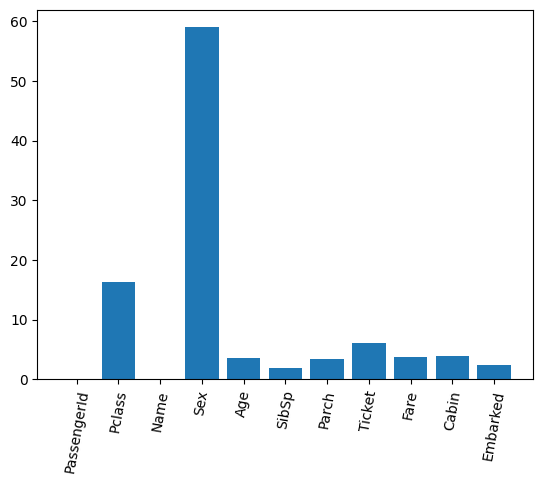

In [49]:
# Show bar plot for feature importance
plt.bar(feature_names, feature_importances)
plt.xticks(rotation=80)
plt.show()

From the above results, we can see that features **`Sex`** and **`Pclass`** had the biggest influence on the result.

### Eval Metrics

The CatBoost has a `eval_metrics` method that allows to calculate a given metrics on a given dataset.

In [50]:
# Create model and fit on training set
model = CatBoostClassifier(iterations=50, random_seed=42, logging_level='Silent')
model.fit(train_pool)
# Eval metrics
eval_metrics = model.eval_metrics(data = validate_pool,
                                  metrics = [metrics.AUC()],               # the list of metrics to be calculated
                                  )
eval_metrics.keys()

dict_keys(['AUC'])

In [51]:
# Eval metric for first 6 iterations
print(eval_metrics['AUC'][:6])

[0.8627368774106994, 0.8623176253563642, 0.8602213650846889, 0.8514170719436525, 0.8495723629045783, 0.8569092738554419]


### Model Saving

It is always really handy to be able to save the model to disk (especially if training took some time). CatBoost have a method named `save_model` just for this purpose.

In [52]:
# Create a model and train on training set
model = CatBoostClassifier(iterations=10, random_seed=42, logging_level='Silent')
model.fit(train_pool)

In [53]:
# Save model
model.save_model('catboost_model.dump')

Once the model is saved we can load it again to use.

In [54]:
# Use the saved model
model = CatBoostClassifier()
model.load_model('catboost_model.dump');

## Parameters Tuning

While we could always select optimal number of iterations (boosting steps) by cross-validation and learning curve plots, it is also important to play with some of model parameters, and we would like to pay some special attention to `l2_leaf_reg` and `learning_rate`.

Here, we'll select these parameters using the **`hyperopt`** package.

**`hyperopt`**'s job is to find the best value of a scalar-valued, possibly-stochastic function over a set of possible arguments to that function. Whereas many optimization packages will assume that these inputs are drawn from a vector space, hyperopt is different in that as it encourages us to describe our search space in more detail. By providing more information about where our function is defined, and where we think the best values are, we allow algorithms in hyperopt to search more efficiently.

To know more about **`hyperopt`**, refer [here](https://hyperopt.github.io/hyperopt/).

To perform hyperparameter optimization, `hyperopt.fmin()` function is used. It iterates on different sets of algorithms and their hyperparameters and then minimizes the objective function.

Some of `hyperopt.fmin()`'s parameters are:

- ***fn***: the objective function to minimize
- ***space***: the space over which to search
- ***trials***: the database in which to store all the point evaluations of the search
- ***algo***: the search algorithm to use such as Random search, TPE (Tree Parzen Estimators), and Adaptive TPE.
    - `hyperopt.rand.suggest` and `hyperopt.tpe.suggest` provides logic for a sequential search of the hyperparameter space

To know more about **`hyperopt.fmin()`**, refer [here](https://github.com/hyperopt/hyperopt/wiki/FMin).

In [55]:
!pip -qq install hyperopt

In [56]:
# Create an objective function which hyperopt needs to minimize
import hyperopt

def hyperopt_objective(params):
    # Create model
    model = CatBoostClassifier(
                               l2_leaf_reg = int(params['l2_leaf_reg']),
                               learning_rate = params['learning_rate'],
                               iterations=500,
                               eval_metric=metrics.Accuracy(),
                               random_seed=42,
                               verbose=False,
                               loss_function=metrics.Logloss()
                               )
    # Perform cross-validation
    cv_data = cv(
                 Pool(X, y, cat_features=categorical_features_indices),
                 model.get_params(),
                 logging_level='Silent'
                 )
    # Best test accuracy
    best_accuracy = np.max(cv_data['test-Accuracy-mean'])

    return 1 - best_accuracy          # as hyperopt minimizes

In [57]:
# Create space over which hyperopt needs to search
'''
   hp.qloguniform(label, low, high, q): returns a value like round(exp(uniform(low, high)) / q) * q
   hp.uniform(label, low, high): returns a value uniformly between low and high
'''
params_space = {
                'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 0, 2, 1),
                'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 5e-1),
                }

In [58]:
# Create trials database to store all the point evaluations of the search
trials = hyperopt.Trials()

In [59]:
# Perform hyperparameter optimization
best = hyperopt.fmin(
                     fn= hyperopt_objective,
                     space= params_space,
                     algo= hyperopt.tpe.suggest,
                     max_evals= 50,
                     trials= trials,
                     )

print(f"Best params values: {best}")

100%|██████████| 50/50 [10:43<00:00, 12.86s/trial, best loss: 0.1661054994388328]
Best params values: {'l2_leaf_reg': 6.0, 'learning_rate': 0.0941146532126365}


Now let's get all cross-validation data with best parameters:

In [60]:
# Create model with best params
model = CatBoostClassifier(
                           l2_leaf_reg=int(best['l2_leaf_reg']),
                           learning_rate=best['learning_rate'],
                           iterations=500,
                           eval_metric=metrics.Accuracy(),
                           random_seed=42,
                           verbose=False,
                           loss_function=metrics.Logloss(),
                           )
# Cross-validation
cv_data = cv(Pool(X, y, cat_features=categorical_features_indices), model.get_params())

Training on fold [0/3]

bestTest = 0.8417508418
bestIteration = 195

Training on fold [1/3]

bestTest = 0.8518518519
bestIteration = 130

Training on fold [2/3]

bestTest = 0.8148148148
bestIteration = 180



In [61]:
# Accuracy score
print('Precise validation accuracy score: {}'.format(np.max(cv_data['test-Accuracy-mean'])))

Precise validation accuracy score: 0.8338945005611672


Recall that with default parameters the cv score was ~0.82, and thereby some improvement can be seen above.